In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
from rfpimp import *
from sklearn.model_selection import train_test_split
from sklearn.base import clone


In [2]:
df_all = pd.read_csv("data/rent-cls.csv") 

num_features = ['bathrooms','bedrooms','latitude','longitude','price']
target = 'interest_level'

df = df_all[num_features + [target]]

In [3]:
# compute median per num bedrooms
df = df.copy()
df_median_price_per_bedrooms = df.groupby(by='bedrooms')['price'].median().reset_index()
beds_to_median = df_median_price_per_bedrooms.to_dict(orient='dict')['price']
df['median_price_per_bedrooms'] = df['bedrooms'].map(beds_to_median)
# compute ratio of price to median price for that num of bedrooms
df['price_to_median_beds'] = df['price'] / df['median_price_per_bedrooms']
# ratio of num bedrooms to price
df["beds_per_price"] = df["bedrooms"] / df["price"] 
# total rooms (bed, bath)
df["beds_baths"] = df["bedrooms"]+df["bathrooms"]
del df['median_price_per_bedrooms'] # don't need after computation

df_train, df_test = train_test_split(df, test_size=0.15)

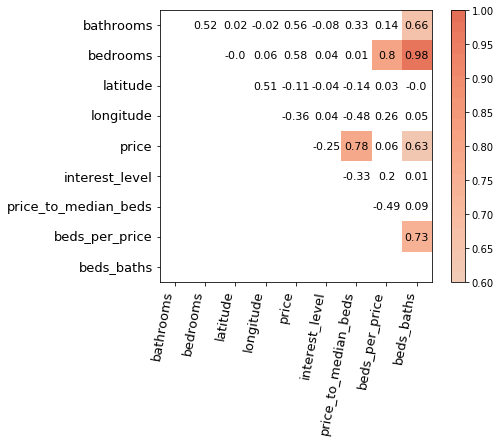

In [4]:
from rfpimp import plot_corr_heatmap
plot_corr_heatmap(df_train, figsize=(7,5), label_fontsize=13, value_fontsize=11)

In [5]:
X_train, y_train = df_train.drop('interest_level',axis=1), df_train['interest_level']
X_test, y_test = df_test.drop('interest_level',axis=1), df_test['interest_level']

rf = RandomForestClassifier(n_estimators=100, n_jobs=-1,
#                            max_features=X_train.shape[1]-1,
                            max_features=1.0,
                            min_samples_leaf=10, oob_score=True)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=1.0, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

Without specifying a feature list, the default is to give you each column as an individual feature:

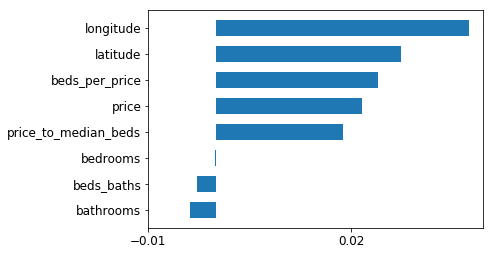

In [6]:
I = importances(rf, X_test, y_test)
plot_importances(I, save='/Users/parrt/github/random-forest-importances/article/images/imp.svg')

But you can specify a subset if you like:

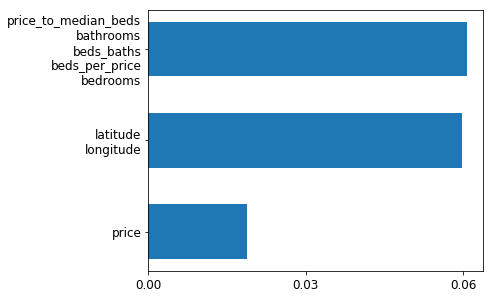

In [7]:
I = importances(rf, X_test, y_test, features=['price',['latitude','longitude']])
plot_importances(I, scalefig=(1,1.2),
                 save='/Users/parrt/github/random-forest-importances/article/images/subset_imp.svg')

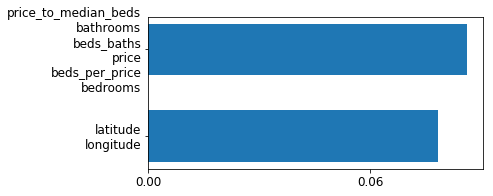

In [8]:
I = importances(rf, X_test, y_test, features=[['latitude','longitude']])
plot_importances(I, scalefig=(1,0.7),
                 save='/Users/parrt/github/random-forest-importances/article/images/latlong_imp.svg')

By specifying a list of lists, you can provide groups that should be treated together.

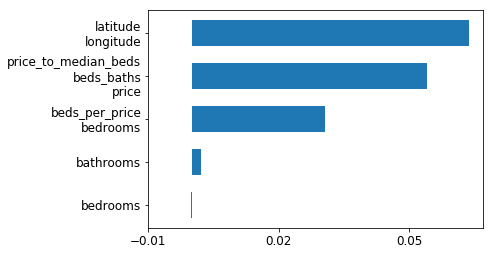

In [9]:
features = ['bathrooms', 'bedrooms', 
            ['latitude', 'longitude'],  
            ['price_to_median_beds', 'beds_baths', 'price'], 
            ['beds_per_price','bedrooms']]
I = importances(rf, X_test, y_test, features=features)
plot_importances(I, save='/Users/parrt/github/random-forest-importances/article/images/grouped_imp.svg')

Features can be duplicated in multiple groups:

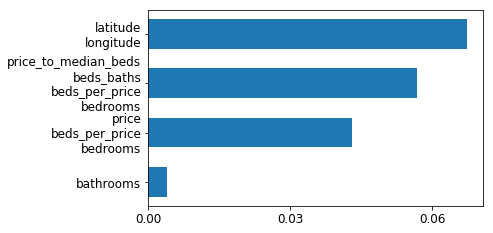

In [10]:
features = [['latitude', 'longitude'],
            ['price_to_median_beds', 'beds_baths', 'beds_per_price', 'bedrooms'],
            ['price','beds_per_price','bedrooms']]
I = importances(rf, X_test, y_test, features=features)
plot_importances(I, scalefig=(1,.9),
                 save='/Users/parrt/github/random-forest-importances/article/images/grouped_dup_imp.svg')